In [4]:
!pip install yt_dlp
!pip install youtube_dl
!pip install ffmpeg
!mkdir youtubeaudio

mkdir: cannot create directory ‘youtubeaudio’: File exists


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
#@title Download Youtube WAV
from __future__ import unicode_literals
import yt_dlp
import ffmpeg
import sys

ydl_opts = {
    'format': 'bestaudio/best',
#    'outtmpl': 'output.%(ext)s',
    'postprocessors': [{
        'key': 'FFmpegExtractAudio',
        'preferredcodec': 'wav',
    }],
    "outtmpl": 'youtubeaudio/audio1',  # this is where you can edit how you'd like the filenames to be formatted
}
def download_from_url(url):
    ydl.download([url])
    # stream = ffmpeg.input('output.m4a')
    # stream = ffmpeg.output(stream, 'output.wav')


with yt_dlp.YoutubeDL(ydl_opts) as ydl:
      url = "https://youtu.be/fKRtnMYMW08" #@param {type:"string"}
      download_from_url(url)





[youtube] Extracting URL: https://youtu.be/fKRtnMYMW08
[youtube] fKRtnMYMW08: Downloading webpage
[youtube] fKRtnMYMW08: Downloading ios player API JSON
[youtube] fKRtnMYMW08: Downloading android player API JSON
[youtube] fKRtnMYMW08: Downloading m3u8 information
[info] fKRtnMYMW08: Downloading 1 format(s): 251
[download] Destination: youtubeaudio/audio1
[download] 100% of    3.62MiB in 00:00:00 at 56.86MiB/s  
[ExtractAudio] Destination: youtubeaudio/audio1.wav
Deleting original file youtubeaudio/audio1 (pass -k to keep)


In [6]:
#@title 2. Install Demucs for Separating Audio
!python3 -m pip install -U demucs

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 60.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.1/87.1 kB 12.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 418.8/418.8 kB 37.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.6/59.6 kB 8.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 180.0/180.0 kB 19.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.7/46.7 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.1/73.1 kB 9.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━

In [ ]:
#@title Separate Vocal and Instrument/Noise using Demucs
import subprocess
AUDIO_INPUT = "/content/drive/MyDrive/Praksismulmed/data.wav" #@param {type:"string"}

command = f"demucs --two-stems=vocals {AUDIO_INPUT}"
result = subprocess.run(command.split(), stdout=subprocess.PIPE)
print(result.stdout.decode())

Important: the default model was recently changed to `htdemucs` the latest Hybrid Transformer Demucs model. In some cases, this model can actually perform worse than previous models. To get back the old default model use `-n mdx_extra_q`.
Selected model is a bag of 1 models. You will see that many progress bars per track.
Separated tracks will be stored in /content/separated/htdemucs
Separating track /content/drive/MyDrive/Praksismulmed/data.wav



In [ ]:
SPEAKER_NAME = "Zib" #@param {type:"string"}
!mkdir -p dataset_raw/{SPEAKER_NAME}

In [ ]:

from scipy.io import wavfile
import os
import numpy as np
import argparse
from tqdm import tqdm
import json

from datetime import datetime, timedelta

# Utility functions

def GetTime(video_seconds):

    if (video_seconds < 0) :
        return 00

    else:
        sec = timedelta(seconds=float(video_seconds))
        d = datetime(1,1,1) + sec

        instant = str(d.hour).zfill(2) + ':' + str(d.minute).zfill(2) + ':' + str(d.second).zfill(2) + str('.001')

        return instant

def GetTotalTime(video_seconds):

    sec = timedelta(seconds=float(video_seconds))
    d = datetime(1,1,1) + sec
    delta = str(d.hour) + ':' + str(d.minute) + ":" + str(d.second)

    return delta

def windows(signal, window_size, step_size):
    if type(window_size) is not int:
        raise AttributeError("Window size must be an integer.")
    if type(step_size) is not int:
        raise AttributeError("Step size must be an integer.")
    for i_start in range(0, len(signal), step_size):
        i_end = i_start + window_size
        if i_end >= len(signal):
            break
        yield signal[i_start:i_end]

def energy(samples):
    return np.sum(np.power(samples, 2.)) / float(len(samples))

def rising_edges(binary_signal):
    previous_value = 0
    index = 0
    for x in binary_signal:
        if x and not previous_value:
            yield index
        previous_value = x
        index += 1

'''
Last Acceptable Values

min_silence_length = 0.3
silence_threshold = 1e-3
step_duration = 0.03/10

'''
# Change the arguments and the input file here
input_file = "/content/drive/MyDrive/Praksismulmed/data.wav" #@param {type:"string"}
output_dir = f"/content/dataset_raw/{SPEAKER_NAME}"
min_silence_length = 0.6  # The minimum length of silence at which a split may occur [seconds]. Defaults to 3 seconds.
silence_threshold = 1e-4  # The energy level (between 0.0 and 1.0) below which the signal is regarded as silent.
step_duration = 0.03/10   # The amount of time to step forward in the input file after calculating energy. Smaller value = slower, but more accurate silence detection. Larger value = faster, but might miss some split opportunities. Defaults to (min-silence-length / 10.).


input_filename = input_file
window_duration = min_silence_length
if step_duration is None:
    step_duration = window_duration / 10.
else:
    step_duration = step_duration

output_filename_prefix = os.path.splitext(os.path.basename(input_filename))[0]
dry_run = False

print("Splitting {} where energy is below {}% for longer than {}s.".format(
    input_filename,
    silence_threshold * 100.,
    window_duration
    )
)

# Read and split the file

sample_rate, samples = input_data=wavfile.read(filename=input_filename, mmap=True)

max_amplitude = np.iinfo(samples.dtype).max
print(max_amplitude)

max_energy = energy([max_amplitude])
print(max_energy)

window_size = int(window_duration * sample_rate)
step_size = int(step_duration * sample_rate)

signal_windows = windows(
    signal=samples,
    window_size=window_size,
    step_size=step_size
)

window_energy = (energy(w) / max_energy for w in tqdm(
    signal_windows,
    total=int(len(samples) / float(step_size))
))

window_silence = (e > silence_threshold for e in window_energy)

cut_times = (r * step_duration for r in rising_edges(window_silence))

# This is the step that takes long, since we force the generators to run.
print("Finding silences...")
cut_samples = [int(t * sample_rate) for t in cut_times]
cut_samples.append(-1)

cut_ranges = [(i, cut_samples[i], cut_samples[i+1]) for i in range(len(cut_samples) - 1)]

video_sub = {str(i) : [str(GetTime(((cut_samples[i])/sample_rate))),
                       str(GetTime(((cut_samples[i+1])/sample_rate)))]
             for i in range(len(cut_samples) - 1)}

for i, start, stop in tqdm(cut_ranges):
    output_file_path = "{}_{:03d}.wav".format(
        os.path.join(output_dir, output_filename_prefix),
        i
    )
    if not dry_run:
        print("Writing file {}".format(output_file_path))
        wavfile.write(
            filename=output_file_path,
            rate=sample_rate,
            data=samples[start:stop]
        )
    else:
        print("Not writing file {}".format(output_file_path))

with open (output_dir+'\\'+output_filename_prefix+'.json', 'w') as output:
    json.dump(video_sub, output)

Splitting /content/drive/MyDrive/Praksismulmed/data.wav where energy is below 0.01% for longer than 0.6s.
32767
1073676289.0


  0%|          | 68/51996 [00:00<01:16, 679.00it/s]

Finding silences...


100%|██████████| 33/33 [00:00<00:00, 763.87it/s]

Writing file /content/dataset_raw/Zib/data_000.wav
Writing file /content/dataset_raw/Zib/data_001.wav
Writing file /content/dataset_raw/Zib/data_002.wav
Writing file /content/dataset_raw/Zib/data_003.wav
Writing file /content/dataset_raw/Zib/data_004.wav
Writing file /content/dataset_raw/Zib/data_005.wav
Writing file /content/dataset_raw/Zib/data_006.wav
Writing file /content/dataset_raw/Zib/data_007.wav
Writing file /content/dataset_raw/Zib/data_008.wav
Writing file /content/dataset_raw/Zib/data_009.wav
Writing file /content/dataset_raw/Zib/data_010.wav
Writing file /content/dataset_raw/Zib/data_011.wav
Writing file /content/dataset_raw/Zib/data_012.wav
Writing file /content/dataset_raw/Zib/data_013.wav
Writing file /content/dataset_raw/Zib/data_014.wav
Writing file /content/dataset_raw/Zib/data_015.wav
Writing file /content/dataset_raw/Zib/data_016.wav
Writing file /content/dataset_raw/Zib/data_017.wav
Writing file /content/dataset_raw/Zib/data_018.wav
Writing file /content/dataset_r

In [ ]:
#@title 4. Install dependencies for Training
!python -m pip install -U pip wheel
%pip install -U ipython
%pip install -U so-vits-svc-fork
!mkdir drive/MyDrive/so-vits-svc-fork

In [ ]:
#@title Automatic preprocessing
!svc pre-resample

Preprocessing:   0% 0/66 [00:00<?, ?it/s][14:21:54] WARNING  [14:21:54]                                   ]8;id=860533;file:///usr/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=636122;file:///usr/lib/python3.10/warnings.py#109\109]8;;\
                    /usr/local/lib/python3.10/dist-packages/libr                
                    osa/util/decorators.py:88: UserWarning:                     
                    PySoundFile failed. Trying audioread                        
                    instead.                                                    
                      return f(*args, **kwargs)                                 
                                                                                
[14:21:54] WARNING  [14:21:54]                                   ]8;id=65397;file:///usr/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=288903;file:///usr/lib/python3.10/warnings.py#109\109]8;;\
                    /usr/local/lib/python3.10/dist-packages/

In [ ]:
!svc pre-config

[13:55:25] INFO     [13:55:25] Version: 4.0.1                     ]8;id=635290;file:///usr/local/lib/python3.10/dist-packages/so_vits_svc_fork/__main__.py\__main__.py]8;;\:]8;id=333332;file:///usr/local/lib/python3.10/dist-packages/so_vits_svc_fork/__main__.py#31\31]8;;\
Usage: svc pre-config [OPTIONS]
Try 'svc pre-config -h' for help.

Error: Invalid value for '-i' / '--input-dir': Path 'dataset/44k' does not exist.


In [ ]:
#@title Copy configs file
!cp configs/44k/config.json drive/MyDrive/so-vits-svc-fork

cp: cannot stat 'configs/44k/config.json': No such file or directory


In [ ]:
F0_METHOD = "harvest" #@param ["crepe", "crepe-tiny", "parselmouth", "dio", "harvest"]
!svc pre-hubert -fm {F0_METHOD}

[13:55:35] INFO     [13:55:35] Version: 4.0.1                     ]8;id=55826;file:///usr/local/lib/python3.10/dist-packages/so_vits_svc_fork/__main__.py\__main__.py]8;;\:]8;id=778400;file:///usr/local/lib/python3.10/dist-packages/so_vits_svc_fork/__main__.py#31\31]8;;\
Usage: svc pre-hubert [OPTIONS]
Try 'svc pre-hubert -h' for help.

Error: Invalid value for '-i' / '--input-dir': Path 'dataset/44k' does not exist.


In [ ]:
#@title Training
%load_ext tensorboard
%tensorboard --logdir drive/MyDrive/so-vits-svc-fork/logs/44k
!svc train --model-path drive/MyDrive/so-vits-svc-fork/logs/44k

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


<IPython.core.display.Javascript object>

[16:19:47] INFO     [16:19:47] Created a temporary directory  ]8;id=638502;file:///usr/local/lib/python3.10/dist-packages/torch/distributed/nn/jit/instantiator.py\instantiator.py]8;;\:]8;id=966249;file:///usr/local/lib/python3.10/dist-packages/torch/distributed/nn/jit/instantiator.py#21\21]8;;\
                    at /tmp/tmp7pig3x_p                                         
           INFO     [16:19:47] Writing                        ]8;id=864747;file:///usr/local/lib/python3.10/dist-packages/torch/distributed/nn/jit/instantiator.py\instantiator.py]8;;\:]8;id=20409;file:///usr/local/lib/python3.10/dist-packages/torch/distributed/nn/jit/instantiator.py#76\76]8;;\
                    /tmp/tmp7pig3x_p/_remote_module_non_scrip                   
                    table.py                                                    
2023-06-08 16:19:49.179270: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
[16:19:49] INFO     [16:19

In [ ]:
#@title 5. Inference
from IPython.display import Audio

AUDIO = "/content/separated/htdemucs/audio1/vocals.wav" #@param {type:"string"}
MODEL = "https://drive.google.com/file/d/13hmYi8mYMIBTr3Swa6iAAPFNsp_RApJJ/view?usp=drive_link" #@param {type:"string"}
CONFIG = "https://drive.google.com/file/d/1-EnJA9cXo6_GjSkUAGCd5YDb4Rr8SPuq/view?usp=drive_link" #@param {type:"string"}
#@markdown Change According to Your Voice Tone. 12 = 1 Octave | -12 = -1 Octave
PITCH = -15 #@param {type:"integer"}

!svc infer {AUDIO} -c {CONFIG} -m {MODEL} -t {PITCH} -af -ap
# Try commenting the line below if you get a Runtime Error
try:
  display(Audio(f"{AUDIO}.out.wav", autoplay=True))
except Exception as e:
  print("Error:", str(e))


[14:10:23] INFO     [14:10:23] Version: 4.0.1                     ]8;id=301183;file:///usr/local/lib/python3.10/dist-packages/so_vits_svc_fork/__main__.py\__main__.py]8;;\:]8;id=413465;file:///usr/local/lib/python3.10/dist-packages/so_vits_svc_fork/__main__.py#31\31]8;;\
Usage: svc infer [OPTIONS] INPUT_PATH
Try 'svc infer -h' for help.

Error: No such option: -f
Error: rate must be specified when data is a numpy array or list of audio samples.


In [ ]:
#@title 6 Combine Vocal and Instrument (Song Cover)
!pip install pydub
from pydub import AudioSegment

VOCAL = "/content/separated/htdemucs/audio1/vocals.out.wav" #@param {type:"string"}
INSTRUMENT = "/content/separated/htdemucs/audio1/no_vocals.wav" #@param {type:"string"}

sound1 = AudioSegment.from_file(VOCAL)
sound2 = AudioSegment.from_file(INSTRUMENT)

combined = sound1.overlay(sound2)

combined.export("/content/FinalCover.wav", format='wav')
try:
  display(Audio(f"/content/FinalCover.wav", autoplay=True))
except Exception as e:  print("Error:", str(e))


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


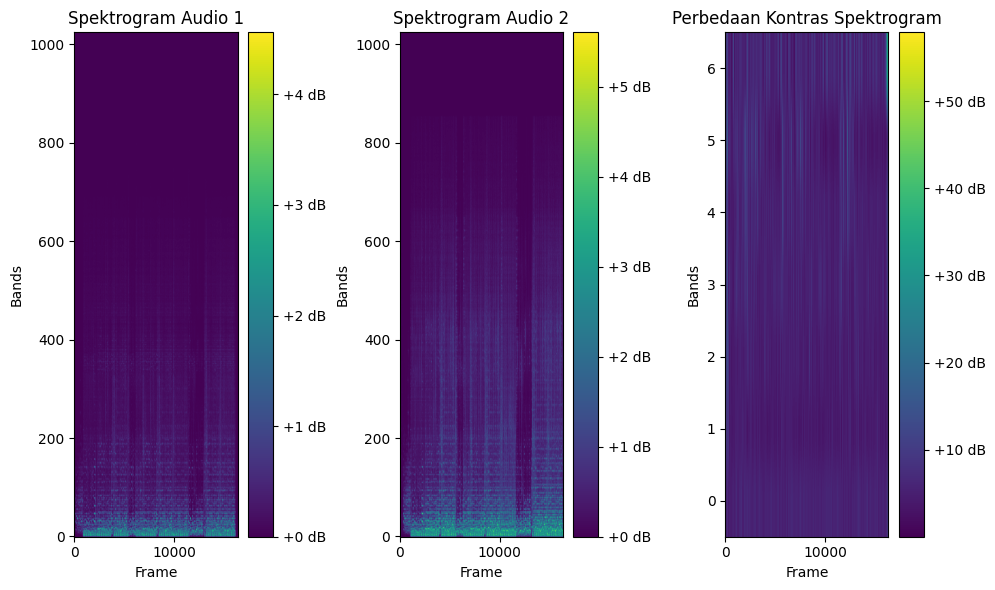

Persentase kemiripan: 78.51%


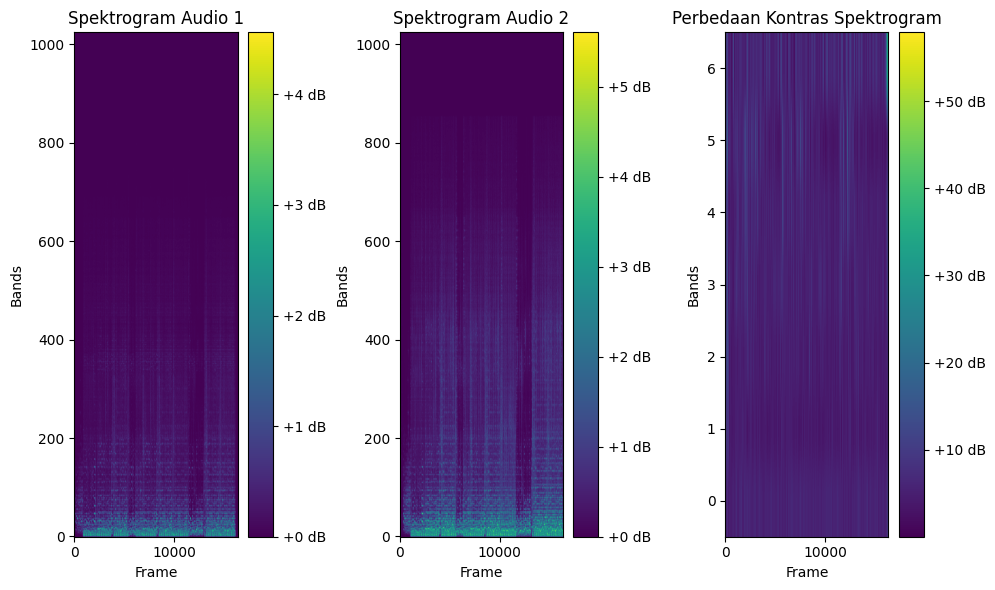

Persentase kemiripan: 78.51%


In [ ]:
import librosa
import numpy as np
import matplotlib.pyplot as plt

def compare_spectrogram(audio_file1, audio_file2):
    # Membaca file audio pertama
    audio1, sr1 = librosa.load(audio_file1, sr=None)

    # Membaca file audio kedua
    audio2, sr2 = librosa.load(audio_file2, sr=None)

    # Menghitung spektrogram audio pertama
    spectrogram1 = np.abs(librosa.stft(audio1))

    # Menghitung spektrogram audio kedua
    spectrogram2 = np.abs(librosa.stft(audio2))

    # Menyamakan jumlah frame
    min_frames = min(spectrogram1.shape[1], spectrogram2.shape[1])
    spectrogram1 = spectrogram1[:, :min_frames]
    spectrogram2 = spectrogram2[:, :min_frames]

    # Menghitung kontras spektrogram
    contrast1 = librosa.feature.spectral_contrast(S=spectrogram1, sr=sr1)
    contrast2 = librosa.feature.spectral_contrast(S=spectrogram2, sr=sr2)

    # Menghitung perbedaan kontras
    contrast_diff = np.abs(contrast1 - contrast2)

    # Plot spektrogram audio pertama
    plt.figure(figsize=(10, 6))
    plt.subplot(1, 3, 1)
    plt.imshow(np.log1p(spectrogram1), aspect='auto', origin='lower')
    plt.colorbar(format='%+2.0f dB')
    plt.xlabel('Frame')
    plt.ylabel('Bands')
    plt.title('Spektrogram Audio 1')

    # Plot spektrogram audio kedua
    plt.subplot(1, 3, 2)
    plt.imshow(np.log1p(spectrogram2), aspect='auto', origin='lower')
    plt.colorbar(format='%+2.0f dB')
    plt.xlabel('Frame')
    plt.ylabel('Bands')
    plt.title('Spektrogram Audio 2')

    # Plot visualisasi perbedaan kontras
    plt.subplot(1, 3, 3)
    plt.imshow(contrast_diff, aspect='auto', origin='lower')
    plt.colorbar(format='%+2.0f dB')
    plt.xlabel('Frame')
    plt.ylabel('Bands')
    plt.title('Perbedaan Kontras Spektrogram')

    plt.tight_layout()
    plt.show()

    # Menghitung persentase kemiripan
    correlation = np.corrcoef(contrast1.flatten(), contrast2.flatten())[0, 1]
    similarity_percentage = correlation * 100
    print("Persentase kemiripan: {:.2f}%".format(similarity_percentage))

def compare_audio(audio_file1, audio_file2):
    compare_spectrogram(audio_file1, audio_file2)

# Contoh penggunaan
audio_file1 = "audio1.wav" #@param{type:"string"}
audio_file2 = "audio.wav" #@param{type:"string"}
compare_audio(audio_file1, audio_file2)
